## 1. Problem Statement

 A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

In [1]:
from google.colab import drive
import os

In [2]:
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [3]:
!pip install contractions
import re, string, unicodedata
import contractions
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import nltk

 # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

from wordcloud import WordCloud,STOPWORDS

from nltk.stem.wordnet import WordNetLemmatizer 
import matplotlib.pyplot as plt   

from sklearn.model_selection import KFold , StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [4]:
## Loading data
data = pd.read_csv('/content/Drive/MyDrive/Files/ML-datasets/Tweets.csv')

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
data.shape

(14640, 15)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


* `Negativereason_confidence` has lot of null values.
*  `Retweet_count` column is highly skewed.

#### Null check

In [9]:
data.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

* airline_sentiment and text do not have any null values. As we only considering these 2 columns. So it's good.

## 2. Exploratory Data Analysis

In [10]:
## unique values

cols=['airline_sentiment','negativereason','airline','retweet_count','tweet_location']
for item in cols:
    print(data[item].value_counts())
    print('\n\n')

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64



Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64



United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64



0     13873
1       640
2        66
3        22
4        17
5         5
7         3
6         3
22        2
8         1
32        1
9         1
31        1
18        1
15        1
28        1
44        1
11        1
Name: retweet_count, dtype: int64



Boston, MA                  157
New York, NY                156
Washington, DC          

* Customer Service Issue, Late Flight and Can't Tell are the top 3 negative reasons.
* United  ,US Airways ,American are top 3 flights customers had written review for.          

In [11]:
### Checking nehative reason is only for negative sentiments

data[data['airline_sentiment'] !='negative']['negativereason'].count()

0

* It shows that negativereason is only provided for negative sentiments.

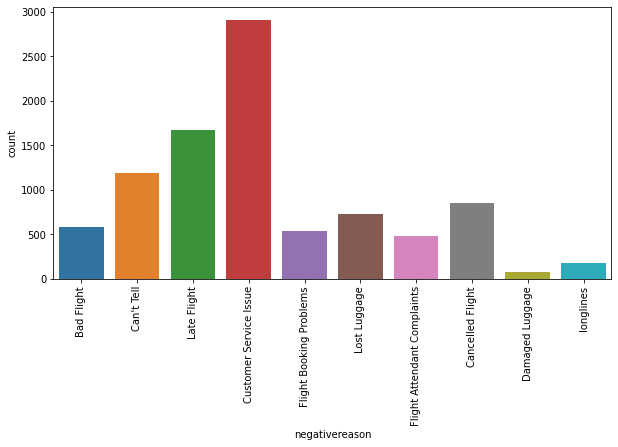

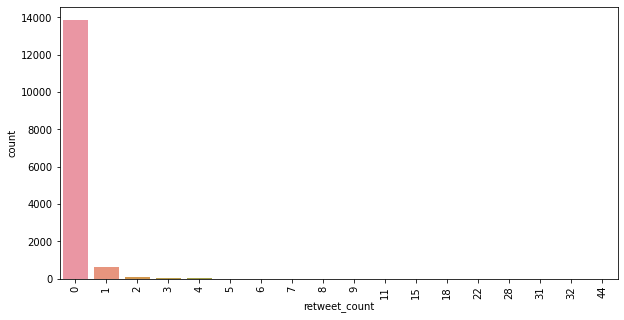

In [12]:
###univariant plot for those columns
cols=['negativereason','retweet_count']

for col in cols:
  plt.figure(figsize=(10,5))
  sns.countplot(data=data, x=col )
  plt.xticks(rotation= 90)
  plt.show()


* Highly reported negative reason is `Customer Service Issue` followed by `Late Flight`.

###  a. Plot the distribution of all tweets among each airline & plot the distribution of sentiment across all the tweets. 

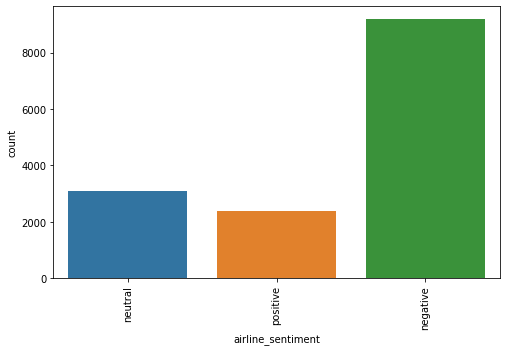

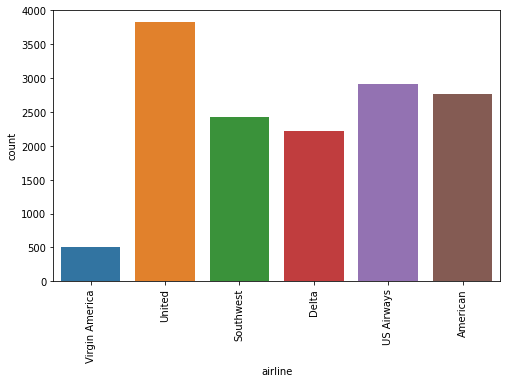

In [13]:
## distribution of sentiments across all the tweets and distribution of tweets 
cols=['airline_sentiment','airline']

for col in cols:
  plt.figure(figsize=(8,5))
  sns.countplot(data=data, x=col )
  plt.xticks(rotation= 90)
  plt.show()


* United Airways has received highest reviews and followed by US Airways.


<Figure size 576x360 with 0 Axes>

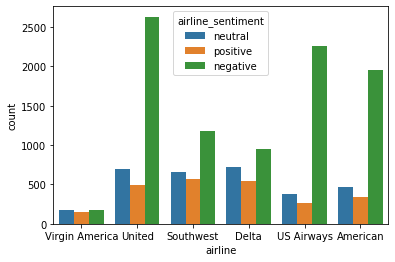

<Figure size 576x360 with 0 Axes>

In [14]:
# Distribution of tweets  across all the airline and sentiments
sns.countplot(data=data,x='airline', hue='airline_sentiment')
plt.figure(figsize=(8,5))

In [15]:
## Total count of tweet for airline and airline_sentiments
airlineBiseSentiments = data.groupby(by=['airline_sentiment','airline']).tweet_id.count().reset_index()
airlineBiseSentiments.columns = ['airline_sentiment','airline','count']
airlineBiseSentiments

,airline_sentiment,airline,count
0,negative,American,1960
1,negative,Delta,955
2,negative,Southwest,1186
3,negative,US Airways,2263
4,negative,United,2633
5,negative,Virgin America,181
6,neutral,American,463
7,neutral,Delta,723
8,neutral,Southwest,664
9,neutral,US Airways,381


* Customer highly reported negative sentiments for `united airways` and positive sentiments for `Southwest airways`.

### b. Plot the distribution of Sentiment of tweets for each airline & plot the distribution of all the negative reasons. 

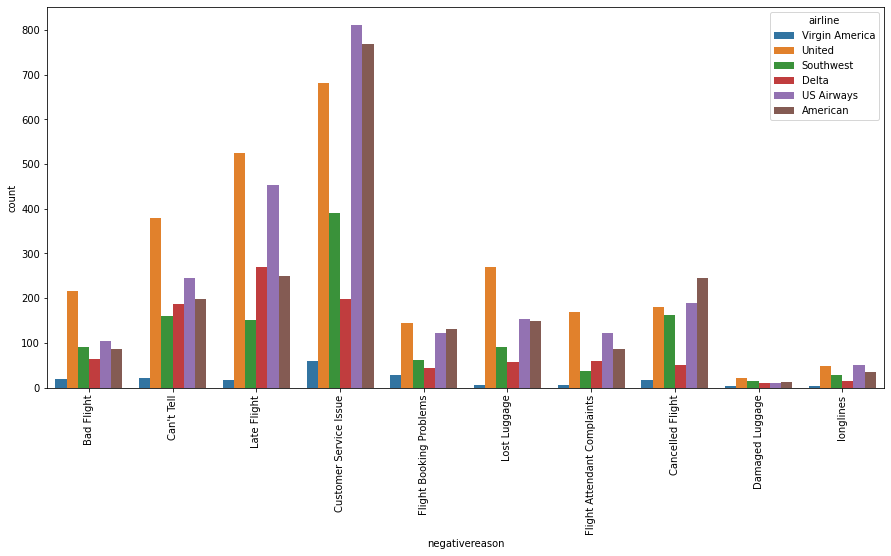

In [16]:
plt.figure(figsize=(15,7))
sns.countplot(data=data, x='negativereason',hue='airline')
plt.xticks(rotation=90)
plt.show()

* Customer highly reported customer service issue for US Airways and followed by American airways and united.
Second highly reported negative reason is Late Flight  for united  and followed by US airways.


In [17]:
## Total count of tweets grouped by different negativereason and airline
airlineNegativeReason=data.groupby(by=['negativereason','airline'],dropna=True).tweet_id.count().reset_index()
airlineNegativeReason.columns = ['negativereason','airline','count']

airlineNegativeReason=airlineNegativeReason.sort_values(by='count')
airlineNegativeReason

,negativereason,airline,count
59,longlines,Virgin America,3
29,Damaged Luggage,Virgin America,4
35,Flight Attendant Complaints,Virgin America,5
53,Lost Luggage,Virgin America,5
27,Damaged Luggage,US Airways,11
25,Damaged Luggage,Delta,11
24,Damaged Luggage,American,12
26,Damaged Luggage,Southwest,14
55,longlines,Delta,14
47,Late Flight,Virgin America,17


### c. Plot the word cloud graph of tweets for positive and negative sentiment separately.

#### Negative word cloud

In [18]:
negative_reviews = data[data['airline_sentiment'] == 'negative']
words = ' '.join(negative_reviews['text'])
cleaned_word_neg = " ".join(word for word in words.split())

In [19]:
wordcloud_neg=WordCloud(stopwords=STOPWORDS,
                    height=2500,width=3000,
                    background_color='black').generate(cleaned_word_neg)

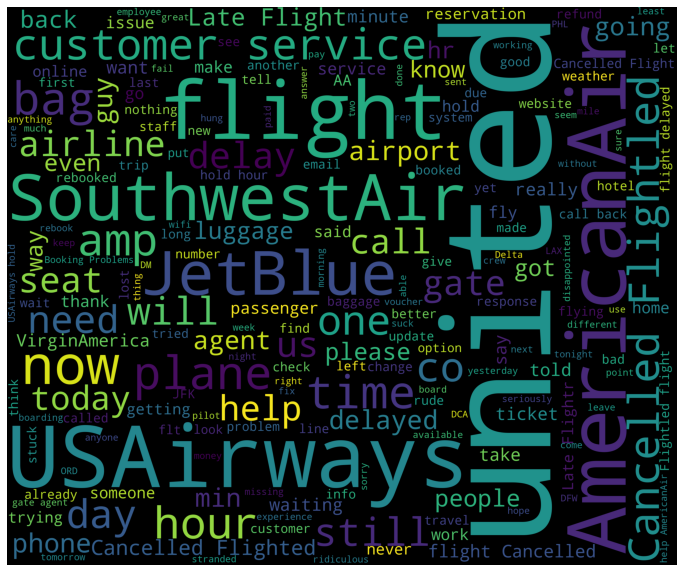

In [20]:
plt.figure(figsize=(12,12))
plt.imshow(wordcloud_neg)
plt.axis('off')
plt.show()

* Highly negative review are related to united airways> USA airways > American Airways
* Highly occured negative reviews are cancelled flight, customer service,delayed, calcelled ehich we  can consider customer service, delayed flight and cancelled flight.

#### Positive Word Cloud

In [21]:
positive_reviews = data[data['airline_sentiment'] == 'positive']
words = ' '.join(positive_reviews['text'])
cleaned_word_pos = " ".join(word for word in words.split())

In [22]:
wordcloud_pos=WordCloud(stopwords=STOPWORDS,
                    height=2500,width=3000,
                    background_color='black').generate(cleaned_word_pos)

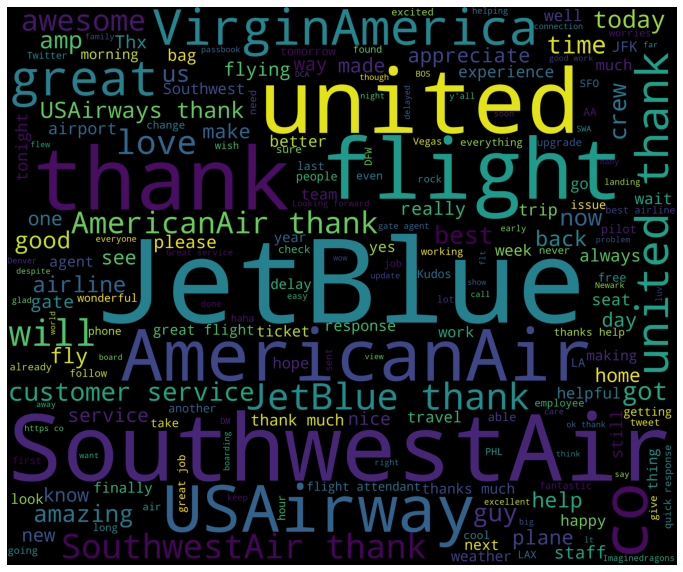

In [23]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud_pos)
plt.axis('off')
plt.show()

* Most of the posivite sentiments are related to United flight> Southwest Air> AmericanAir> USAirway.
* Most occured positive feedback are thanks, Customer service, amazing,awesome.

## 3. Understand of data columns: 

In [24]:
  ### . Drop all other columns except “text” and “airline_sentiment”.
  review = data[['airline_sentiment','text']]


In [25]:
review.shape

(14640, 2)

In [26]:
review.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## 4. Text Processing

     a. Html tag removal.
     b. Tokenization.
     c. Remove the numbers.
     d. Removal of Special Characters and Punctuations.
     e. Removal of stopwords
     f. Conversion to lowercase.
     g. Lemmatize or stemming.
     h. Join the words in the list to convert back to text string in the data frame. (So that each row
          contains the data in text format.)
     i. Print the first 5 rows of data after pre-processing.




In [27]:
## HTML tag removal
def htmlTagRemoval(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

# remove contractions
def replace_contractions(text):
    contractions.fix(text)

# Remove number
def removeNumber(text):
    re.sub(r'\d+','',text)

# Remove special character
def removeSpecialChar(text):
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

def cleanText(text):
  htmlTagRemoval(text)
  replace_contractions(text)
  removeNumber(text)
  removeSpecialChar(text)
  return text

review['text']=review['text'].apply(lambda x: cleanText(x))
review.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [28]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
#Tokeniztion
review['text']= review.apply(lambda row: nltk.word_tokenize(row['text']),axis=1)
review.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,airline_sentiment,text
0,neutral,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,positive,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,neutral,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,negative,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,negative,"[@, VirginAmerica, and, it, 's, a, really, big..."


In [30]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
#stopwords and remove not and no
stopwords = stopwords.words('english')
stopwords=list(set(stopwords))

stopwords.remove('no')
stopwords.remove('not')


In [32]:
#initilize wordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [33]:
##processing of text


# Remove the hashtags
def remove_hash(words):
   """Remove hashtags from list of tokenized words"""
   new_words = []
   for word in words:
     new_word = re.sub(r'#\w+','',word)
     if new_word != '':
       new_words.append(new_word)
   return new_words

# convert all characters to lowercase
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

# Remove the punctuations
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

# Remove the stop words
def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

# lemmatize the words
def lemmatize_list(words):
    new_words = []
    for word in words:
      new_words.append(lemmatizer.lemmatize(word, pos='v'))
    return new_words

def normalize(words):
    words = remove_hash(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    words = lemmatize_list(words)
    return ' '.join(words)

#data['review'] = data['review'].astype(str)
nltk.download('wordnet')
review['text'] = review.apply(lambda row: normalize(row['text']), axis=1)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [34]:
review.head()

,airline_sentiment,text
0,neutral,virginamerica dhepburn say
1,positive,virginamerica plus add commercials experience ...
2,neutral,virginamerica nt today must mean need take ano...
3,negative,virginamerica really aggressive blast obnoxiou...
4,negative,virginamerica really big bad thing


## 5.Vectorization

#### a. CountVectorization

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

countVec = CountVectorizer(max_features=1000,ngram_range=(1,1))
data_features_c = countVec.fit_transform(review['text'])
data_features_c=data_features_c.toarray()

In [36]:
data_features_c.shape

(14640, 1000)

#### b. TfidfVectorization

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvector=TfidfVectorizer(max_features=1000,ngram_range=(1,2))
data_features_t=tfidfvector.fit_transform(review['text'])
data_features_t=data_features_t.toarray()
data_features_t.shape

(14640, 1000)

In [38]:
y=review['airline_sentiment']
y

0         neutral
1        positive
2         neutral
3        negative
4        negative
           ...   
14635    positive
14636    negative
14637     neutral
14638    negative
14639     neutral
Name: airline_sentiment, Length: 14640, dtype: object

In [39]:
labels = {
    "positive":0,
    "neutral":1,
    "negative":2
}

def convert_to_label(x):

  if x == "positive":
    x=0
  elif x == "neutral":
    x=1
  elif x == "negative":
    x = 2
  
  return x
review['airline_sentiment'] =review['airline_sentiment'].apply(lambda x: convert_to_label(x))
review['airline_sentiment']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0        1
1        0
2        1
3        2
4        2
        ..
14635    0
14636    2
14637    1
14638    2
14639    1
Name: airline_sentiment, Length: 14640, dtype: int64

In [40]:
y=review['airline_sentiment']

### Splitting  train and test data set

In [41]:
from sklearn.model_selection import train_test_split
X_train_c, X_test_c, y_train_c, y_test_c=train_test_split(data_features_c,y,test_size=.25, shuffle=False)
X_train_t, X_test_t, y_train_t, y_test_t=train_test_split(data_features_t,y,test_size=.25, shuffle=False)


## 6. Model Building

### a. Model fitting for Count vectorized data

In [42]:
# K-Fold Cross - validation .
base_ln =[100,200,300]
cv_scores = []
for b in base_ln:
    clf = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf, X_train_c, y_train_c, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

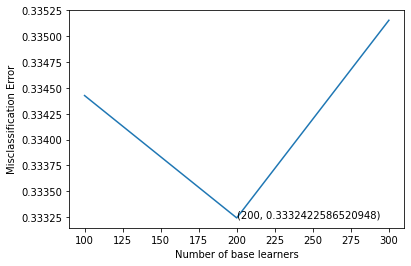

In [43]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

* optimal learners is 100.

In [44]:
y.unique()

array([1, 0, 2])

In [45]:
# Training the best model and calculating accuracy on test data .
clf = RandomForestClassifier(n_estimators = optimal_learners)
clf.fit(X_train_c, y_train_c)
clf.score(X_test_c, y_test_c)
c_predicted = clf.predict(X_test_c)
print(classification_report(y_test_c , c_predicted , target_names = ['positive','neutral', 'negative']))
print("Accuracy of the model is : ",accuracy_score(y_test_c,c_predicted))

              precision    recall  f1-score   support

    positive       0.71      0.61      0.66       456
     neutral       0.55      0.41      0.47       577
    negative       0.85      0.92      0.88      2627

    accuracy                           0.80      3660
   macro avg       0.70      0.65      0.67      3660
weighted avg       0.78      0.80      0.79      3660

Accuracy of the model is :  0.7983606557377049


[[ 278   39  139]
 [  45  236  296]
 [  67  152 2408]]


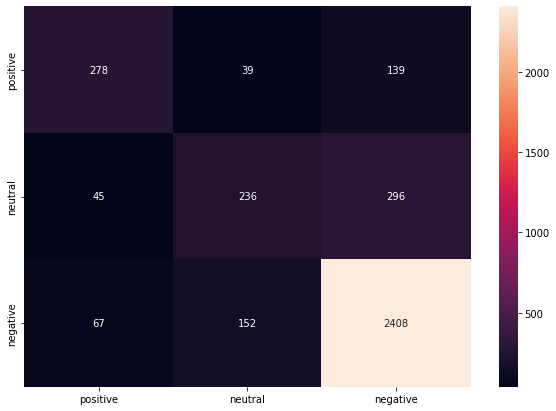

In [46]:
## Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
from sklearn.metrics import confusion_matrix
con_mat=confusion_matrix(y_test_c, c_predicted)
print(con_mat)
df_cm_c = pd.DataFrame(con_mat, index = ['positive','neutral', 'negative'],
                  columns = ['positive','neutral', 'negative'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_c, annot=True, fmt='g')

#### Print the top 40 features and plot their word cloud 

In [47]:
all_features_c = countVec.get_feature_names()
top_feats = ''
features = clf.feature_importances_
featSort=np.argsort(features)[::-1]
for i in featSort[0:40]:
  top_feats+=all_features_c[i]
  top_feats+=','

print(top_feats)

thank,nt,not,no,usairways,delay,unite,great,jetblue,http,flight,southwestair,love,hold,hours,awesome,get,bag,cancel,wait,hour,virginamerica,amaze,time,best,please,fly,make,customer,service,dm,go,help,would,good,call,need,lose,plane,follow,


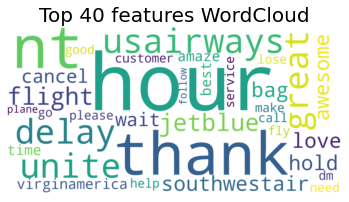

In [48]:
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_feats)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

* Some highly referenced air lines are US-airways,unite air-line,southwest airline and virginamerica
* some highly occured sentiments are hours,thanks,delay,great,cancel,flight,awesome,customer service,love,jetblue,hold

### b. Model fitting for TF-IDF vectorized data

In [49]:
# K-Fold Cross - validation .
base_ln =[100,200,300]
cv_scores_t = []
for b in base_ln:
    clf_t = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf_t, X_train_t, y_train_t, cv = 5, scoring = 'accuracy')
    cv_scores_t.append(scores.mean())

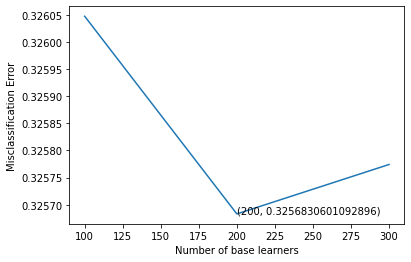

In [50]:
# plotting the error as k increases
error = [1 - x for x in cv_scores_t]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [51]:
# Training the best model and calculating accuracy on test data .
clf_t = RandomForestClassifier(n_estimators = optimal_learners)
clf_t.fit(X_train_t, y_train_t)
clf_t.score(X_test_t, y_test_t)
t_predicted = clf_t.predict(X_test_t)
print(classification_report(y_test_t , t_predicted , target_names = ['positive','neutral', 'negative']))
print("Accuracy of the model is : ",accuracy_score(y_test_t,t_predicted))

              precision    recall  f1-score   support

    positive       0.73      0.58      0.65       456
     neutral       0.63      0.22      0.33       577
    negative       0.82      0.96      0.88      2627

    accuracy                           0.80      3660
   macro avg       0.72      0.59      0.62      3660
weighted avg       0.77      0.80      0.76      3660

Accuracy of the model is :  0.7959016393442623


[[ 265   25  166]
 [  43  128  406]
 [  57   50 2520]]


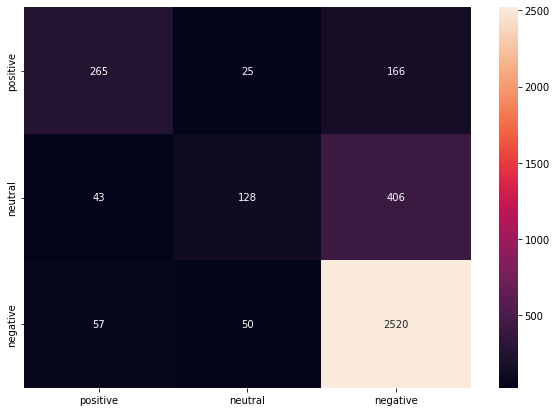

In [52]:
## Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
from sklearn.metrics import confusion_matrix
con_mat_t=confusion_matrix(y_test_t, t_predicted)
print(con_mat_t)
df_cm_t = pd.DataFrame(con_mat_t, index = ['positive','neutral', 'negative'],
                  columns = ['positive','neutral', 'negative'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_t, annot=True, fmt='g')

#### Print the top 40 features and plot their word cloud 

In [53]:
all_features_t = tfidfvector.get_feature_names()
top_features = ''
features = clf_t.feature_importances_
featSort=np.argsort(features)[::-1]
for i in featSort[0:40]:
  top_features+=all_features_c[i]
  top_features+=','

print(top_features)

suitcase,imagine,shit,treat,unhelpful,hope,number,non,frustrate,currently,need,excite,visit,live,avgeek,tv,happen,inconvenience,fly,high,airways,back,vouchers,sister,feb,denver,platinum,bump,front,bank,helpful,file,look,ta,san,gt,agent,minutes,friday,plan,


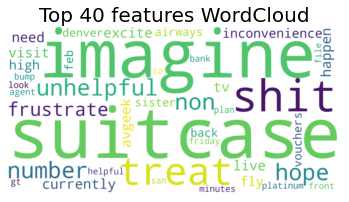

In [54]:
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_features)


# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

* some highly occured sentiments are suitcase,shit, imagine,unhelpful,frustrate,treat etc.



### Lets make model with bi-grams 

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvector_bi=TfidfVectorizer(max_features=1000,ngram_range=(2,2))
data_features_bi=tfidfvector_bi.fit_transform(review['text'])
data_features_bi=data_features_bi.toarray()
data_features_bi.shape

(14640, 1000)

In [56]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi=train_test_split(data_features_bi,y,test_size=.25, shuffle=False)


In [57]:
# K-Fold Cross - validation .
base_ln =[100,200,300]
cv_scores = []
for b in base_ln:
    clf_bi = RandomForestClassifier(n_estimators = b)
    scores = cross_val_score(clf_bi, X_train_bi, y_train_bi, cv = 5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

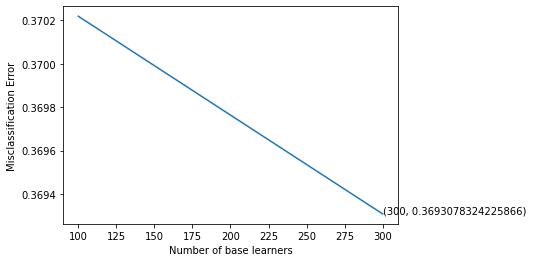

In [58]:
# plotting the error as k increases
error = [1 - x for x in cv_scores]                                 #error corresponds to each nu of estimator
optimal_learners = base_ln[error.index(min(error))]                #Selection of optimal nu of n_estimator corresponds to minimum error.
plt.plot(base_ln, error)                                           #Plot between each nu of estimator and misclassification error
xy = (optimal_learners, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of base learners")
plt.ylabel("Misclassification Error")
plt.show()

In [59]:
y.unique()

array([1, 0, 2])

In [60]:
# Training the best model and calculating accuracy on test data .
clf_bi = RandomForestClassifier(n_estimators = optimal_learners)
clf_bi.fit(X_train_bi, y_train_bi)
clf_bi.score(X_test_bi, y_test_bi)
bi_predicted = clf_bi.predict(X_test_bi)
print(classification_report(y_test_bi , bi_predicted , target_names = ['positive','neutral', 'negative']))
print("Accuracy of the model is : ",accuracy_score(y_test_bi,bi_predicted))

              precision    recall  f1-score   support

    positive       0.60      0.26      0.36       456
     neutral       0.29      0.13      0.18       577
    negative       0.76      0.92      0.83      2627

    accuracy                           0.72      3660
   macro avg       0.55      0.44      0.46      3660
weighted avg       0.66      0.72      0.67      3660

Accuracy of the model is :  0.7158469945355191


[[ 119   29  308]
 [  28   73  476]
 [  51  148 2428]]


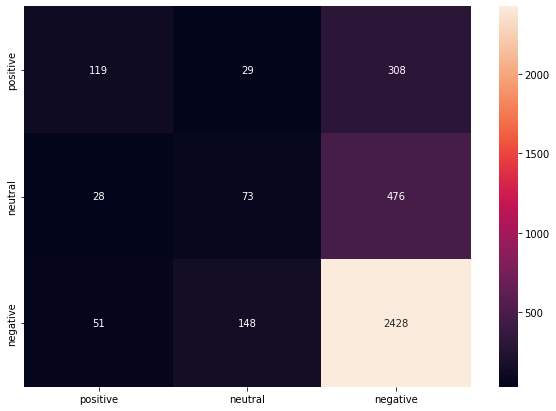

In [61]:
## Print and plot Confusion matirx to get an idea of how the distribution of the prediction is, among all the classes.
from sklearn.metrics import confusion_matrix
con_mat=confusion_matrix(y_test_bi, bi_predicted)
print(con_mat)
df_cm_bi = pd.DataFrame(con_mat, index = ['positive','neutral', 'negative'],
                  columns = ['positive','neutral', 'negative'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_bi, annot=True, fmt='g')

#### Print the top 40 features and plot their word cloud 

In [62]:
all_features_bi = tfidfvector_bi.get_feature_names()
top_feats = ''
features = clf_bi.feature_importances_
featSort=np.argsort(features)[::-1]
for i in featSort[0:40]:
  top_feats+=all_features_bi[i]
  top_feats+=','

print(top_feats)

jetblue thank,unite thank,southwestair thank,customer service,thank much,ca nt,cancel flightled,cancel flight,fleet fleek,virginamerica thank,late flight,thank help,great flight,fleek http,jetblue fleet,flight delay,wo nt,usairways thank,jetblue great,late flightr,delay flight,southwestair love,jetblue airways,no one,southwestair great,great job,best airline,southwestair get,nt wait,awesome thank,look forward,no worry,unite flight,flight cancel,would love,unite hi,usairways hold,hour delay,unite not,could nt,


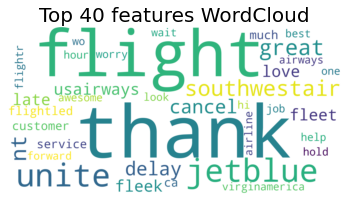

In [63]:
wordcloud = WordCloud(background_color="white",colormap='viridis',width=2000, 
                          height=1000).generate(top_feats)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.figure(1, figsize=(14, 11), frameon='equal')
plt.title('Top 40 features WordCloud', fontsize=20)
plt.axis("off")
plt.show()

* the most occured words are southwestair, us airways,thank,unitairways, virginamerica,cancel,delay, great, worry,fleek,hold etc

### compare all of the models using countVector and Tf-IDF Vector

In [64]:
#convert the test samples into a dataframe where the columns are
#the y_test(ground truth labels),tf-idf model predicted labels(tf_idf_predicted),Count Vectorizer model predicted labels(count_vectorizer_predicted)
df = pd.DataFrame(y_test_t.tolist(),columns =['y_test'])
df['count_vectorizer_predicted'] = c_predicted
df['tf_idf_predicted'] = t_predicted
df['bigram_predicted']=bi_predicted
df.head()

,y_test,count_vectorizer_predicted,tf_idf_predicted,bigram_predicted
0,2,2,2,2
1,2,2,2,2
2,2,2,2,0
3,2,2,2,2
4,0,2,2,2


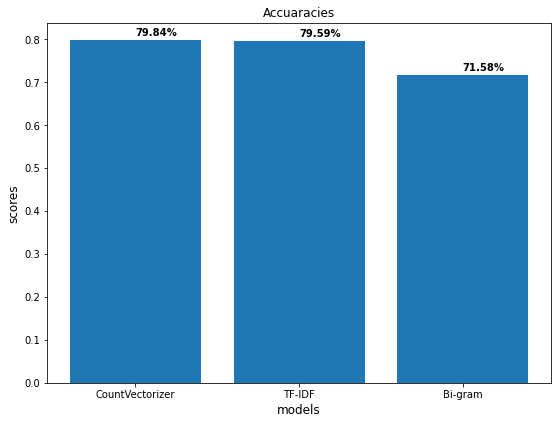

In [65]:
#create bar plot to compare the accuaracies of Count Vectorizer and TF-IDF
fig = plt.figure(figsize=(7,5))
ax = fig.add_axes([0,0,1,1])
subjects = ['CountVectorizer', 'TF-IDF','Bi-gram']

# calculation accuracies of Count Vectorizer and TF-IDF using accuracy_score metrics
scores = [accuracy_score(y_test_c,c_predicted),accuracy_score(y_test_t,t_predicted),accuracy_score(y_test_bi,bi_predicted)]
ax.bar(subjects,scores)
ax.set_ylabel('scores',fontsize= 12)    # y axis label
ax.set_xlabel('models',fontsize= 12)    # x axis label
ax.set_title('Accuaracies')  # tittle
for i, v in enumerate(scores):
    ax.text( i ,v+0.01, '{:.2f}%'.format(100*v), color='black', fontweight='bold')     
    
plt.show()

 Accuracy of model built using TF-IDF vectorizer is better than other models.

## 7. Understanding of the application of Various Pre-processing and Vectorization and the performance of your model on this dataset



* Customer highly reported negative sentiments for `united airways` and positive sentiments for `Southwest airways`.
* Customer Service Issue, Late Flight and Can't Tell are the top 3 negative reasons for United  ,US Airways ,American .
* Customer highly reported customer service issue for US Airways and American airways.
Second highly reported negative reason is Late Flight  for united  and followed by US airways.
* Highly occured negative reviews are cancelled flight, customer service,delayed, calcelled for US airways and American airways

* Model
** Model built using TF-IDF vectorizer has good accuracy but I could not find clear sentiments by plotting word cloud using that model.
** Model build using count vectorizer has a bit less accuracy but better word cloud for sentiments.

* Overall sentiments for US airways, American airways and united airways is negative.
